In [2]:
!nvidia-smi

Fri Mar 18 13:01:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential, load_model
from keras.datasets import mnist
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


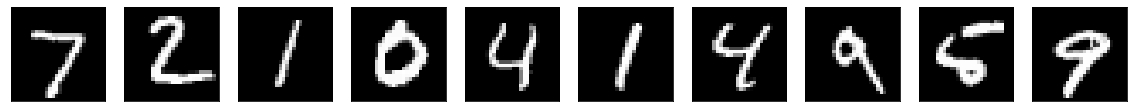

In [4]:
import matplotlib.pyplot as plt

n = 10  # 显示的记录数
plt.figure(figsize=(20, 4))
for i in range(n):
    # 显示原始图片
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
plt.show()

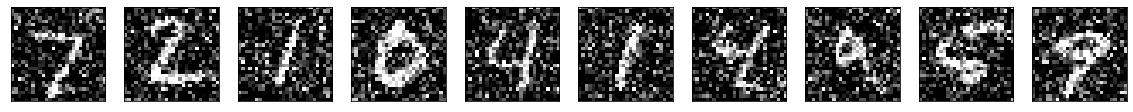

In [5]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [3]:
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
# from keras.models import Model
 
# # 编码过程
# input_img = Input(shape=(28, 28, 1))  
 
# ############
# # 编码 #
# ############
 
# # Conv1 #
# x = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
 
# # Conv2 #
# x = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
 
# # Conv 3 #
# x = Conv2D(filters = 32,kernel_size = (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
 
# # 注意:
# # padding 是一个超参数，值'valid' or 'same'. 
# # "valid" 意味不需要填充 
# # "same" 填充输入，使输出具有与原始输入相同的长度。 

# ############
# # 解码 #
# ############
 
# # DeConv1
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
 
# # DeConv2
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
 
# # Deconv3
# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # 声明模型
# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')



In [6]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,MaxPooling2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

model=Sequential()
#layer_1
model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(28, 28, 1),padding='same',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
# model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',data_format='channels_last',kernel_initializer='uniform',activation='relu'))
model.add(MaxPooling2D((2,2), padding='same'))

#layer_2
model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
# model.add(Conv2D(128,(2,2),strides=(1,1),padding='same',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D((2,2), padding='same'))

#layer_3
model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
# model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
# model.add(Conv2D(256, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
model.add(MaxPooling2D((2,2), padding='same'))
#layer_4
model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
# model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
# model.add(Conv2D(512, (1,1), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
model.add(MaxPooling2D((2,2), padding='same'))

#layer_5
# model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
# model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
# model.add(Conv2D(512, (1,1), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
# model.add(MaxPooling2D((2,2)))


# deconv_4
# model.add(Conv2D(512, (1,1), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
# model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
model.add(UpSampling2D((2,2)))

# deconv_3
# model.add(Conv2D(256, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', activation='relu'))
# model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu'))
model.add(UpSampling2D((2,2)))

# deconv_2
# model.add(Conv2D(128,(2,2),strides=(1,1),padding='same',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',data_format='channels_last',activation='relu',kernel_initializer='uniform'))
model.add(UpSampling2D((2,2)))

# deconv_1
# model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',data_format='channels_last',kernel_initializer='uniform',activation='relu'))
model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(28, 28, 1),data_format='channels_last',activation='relu',kernel_initializer='uniform'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
model.summary()

# Classification 
# model.add(Flatten())  #拉平
# model.add(Dense(4096,activation='relu'))
# model.add(Dense(4096,activation='relu'))
# model.add(Dense(1000,activation='relu'))
# model.add(Dense(10,activation='softmax'))

# model.summary()
model.compile(optimizer='adadelta',loss='binary_crossentropy')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [ ]:
history = model.fit(x_train_noisy, x_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
               )

Epoch 1/1000
469/469 [==============================] - 44s 71ms/step - loss: 0.2153 - val_loss: 0.2148
Epoch 2/1000
469/469 [==============================] - 32s 68ms/step - loss: 0.2146 - val_loss: 0.2141
Epoch 3/1000
469/469 [==============================] - 31s 67ms/step - loss: 0.2139 - val_loss: 0.2134
Epoch 4/1000
469/469 [==============================] - 31s 67ms/step - loss: 0.2132 - val_loss: 0.2127
Epoch 5/1000
469/469 [==============================] - 31s 67ms/step - loss: 0.2126 - val_loss: 0.2120
Epoch 6/1000
469/469 [==============================] - 31s 66ms/step - loss: 0.2120 - val_loss: 0.2116
Epoch 7/1000
469/469 [==============================] - 31s 66ms/step - loss: 0.2114 - val_loss: 0.2108
Epoch 8/1000
469/469 [==============================] - 31s 66ms/step - loss: 0.2108 - val_loss: 0.2102
Epoch 9/1000
469/469 [==============================] - 31s 66ms/step - loss: 0.2102 - val_loss: 0.2099
Epoch 10/1000
469/469 [==============================] - 31s 66m

In [ ]:
def plot_training_loss(history): 
 
  loss = history.history['loss'] 
  val_loss = history.history['val_loss'] 
 
  epochs = range(1, len(loss) + 1) 
 
  plt.plot(epochs, loss, 'bo', label='Training loss') 
  plt.plot(epochs, val_loss, 'r', label='Validation loss') 
  plt.title('Training and validation loss') 
  plt.xlabel('Epochs') 
  plt.ylabel('Loss') 
  plt.legend() 
 
  plt.show() 
 
plot_training_loss(history)

In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          18464 

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
               )

In [ ]:
decoded_imgs = model.predict(x_test)
 
n = 10
 
plt.figure(figsize=(20, 4))
for i in range(n):
    # 显示原始图像
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 显示原始图像
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # 显示重构后的图像
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [ ]:
decoded_imgs = model.predict(x_train)
 
n = 10
 
plt.figure(figsize=(20, 4))
for i in range(n):
    # 显示原始图像
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 显示原始图像
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # 显示重构后的图像
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
!cd drive

drive  sample_data


In [8]:
model.load_weights("/content/drive/MyDrive/DAE_weights_1.h5")

In [ ]:
model.save_weights("/content/drive/MyDrive/DAE_weights_2.h5")